# London Air Pollution 

This notebook performs some EDA on data from the [London Air](https://www.londonair.org.uk/LondonAir/API/) API for 2023. 

https://api.erg.ic.ac.uk/AirQuality/Information/Documentation/pdf - Documentation

https://api.erg.ic.ac.uk/AirQuality/help - API call reference

The objective is to call the API, use SQL to identify the relevant data, and visualise air pollution within a certain area on a map over the course of a day. 

It uses the Folium package for map visualisation.


In [9]:
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns


Let's get data for the latest day first to understand the structure.

In [4]:
# Function to fetch data from the London Air API
def fetch_air_quality_data():
    url = "https://api.erg.ic.ac.uk/AirQuality/Daily/MonitoringIndex/Latest/GroupName=London/Json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print("Data retrieved for latest day")
        return data
    else:
        print("Failed to fetch data")
        return None


In [5]:
# Fetch and process data
data = fetch_air_quality_data()

Data retrieved for latest day


In [6]:
print(data)

{'DailyAirQualityIndex': {'@MonitoringIndexDate': '2024-05-23 00:00:00', '@GroupName': 'London', '@TimeToLive': '49', 'LocalAuthority': [{'@LocalAuthorityCode': '1', '@LocalAuthorityName': 'Barking and Dagenham', '@LaCentreLatitude': '51.538435', '@LaCentreLongitude': '0.11467', '@LaCentreLatitudeWGS84': '6717095.01808', '@LaCentreLongitudeWGS84': '12765.0060093', 'Site': [{'@BulletinDate': '2024-05-23 00:00:00', '@SiteCode': 'BG1', '@SiteName': 'Barking and Dagenham - Rush Green', '@SiteType': 'Suburban', '@Latitude': '51.563752', '@Longitude': '0.177891', '@LatitudeWGS84': '6721627.34498', '@LongitudeWGS84': '19802.7355367', 'Species': [{'@SpeciesCode': 'NO2', '@SpeciesDescription': 'Nitrogen Dioxide', '@AirQualityIndex': '1', '@AirQualityBand': 'Low', '@IndexSource': 'Measurement'}, {'@SpeciesCode': 'SO2', '@SpeciesDescription': 'Sulphur Dioxide', '@AirQualityIndex': '1', '@AirQualityBand': 'Low', '@IndexSource': 'Measurement'}]}, {'@BulletinDate': '2024-05-23 00:00:00', '@SiteCode'

This is a mess - after looking at it, these are the variables: 

#### DailyAirQualityIndex:

    @MonitoringIndexDate: Date of monitoring (2024-05-21).
    @GroupName: Group name (London).
    @TimeToLive: Time to live for the data (59).

#### LocalAuthority:

    @LocalAuthorityCode: Unique code for the local authority.

    @LocalAuthorityName: Name of the local authority.

    @LaCentreLatitude: Latitude of the local authority center.

    @LaCentreLongitude: Longitude of the local authority center.

    @LaCentreLatitudeWGS84: Latitude in WGS84 format.

    @LaCentreLongitudeWGS84: Longitude in WGS84 format.

    Site (within each LocalAuthority):

        @BulletinDate: Date of the bulletin (2024-05-21).

        @SiteCode: Unique code for the monitoring site.

        @SiteName: Name of the monitoring site.

        @SiteType: Type of site (e.g., Suburban, Roadside).

        @Latitude: Latitude of the site.

        @Longitude: Longitude of the site.

        @LatitudeWGS84: Latitude in WGS84 format.

        @LongitudeWGS84: Longitude in WGS84 format.

        Species (within each Site):

            @SpeciesCode: Code for the pollutant species (e.g., NO2, SO2).
            @SpeciesDescription: Description of the pollutant species (e.g., Nitrogen Dioxide, Sulphur Dioxide).
            @AirQualityIndex: Air quality index value.
            @AirQualityBand: Air quality band (e.g., Low).
            @IndexSource: Source of the index (e.g., Measurement).


So to normalise this into separate tables, it makes sense to split into authorities, sites and species. 

In [7]:
authorities = data['DailyAirQualityIndex']['LocalAuthority']
df_authorities = pd.json_normalize(authorities)

# Normalize sites within each authority
site_data = []
for authority in authorities:
    if isinstance(authority.get('Site'), list):
        for site in authority['Site']:
            site['LocalAuthorityName'] = authority['@LocalAuthorityName']
            site['LocalAuthorityCode'] = authority['@LocalAuthorityCode']
            site_data.append(site)

df_sites = pd.json_normalize(site_data)

# Normalize species within each site
species_data = []
for site in site_data:
    if isinstance(site.get('Species'), list):
        for species in site['Species']:
            species['SiteCode'] = site['@SiteCode']
            species['SiteName'] = site['@SiteName']
            species_data.append(species)

df_species = pd.json_normalize(species_data)


Now some general cleanup: 


In [8]:
# Remove special characters from column names
df_authorities.columns = [col.replace('@', '') for col in df_authorities.columns]
df_sites.columns = [col.replace('@', '') for col in df_sites.columns]
df_species.columns = [col.replace('@', '') for col in df_species.columns]

# Ensure all columns are of appropriate data types
df_authorities = df_authorities.map(lambda x: str(x) if isinstance(x, list) else x)
df_sites = df_sites.map(lambda x: str(x) if isinstance(x, list) else x)
df_species = df_species.map(lambda x: str(x) if isinstance(x, list) else x)

# Convert all columns to string type to avoid issues
df_authorities = df_authorities.astype(str)
df_sites = df_sites.astype(str)
df_species = df_species.astype(str)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


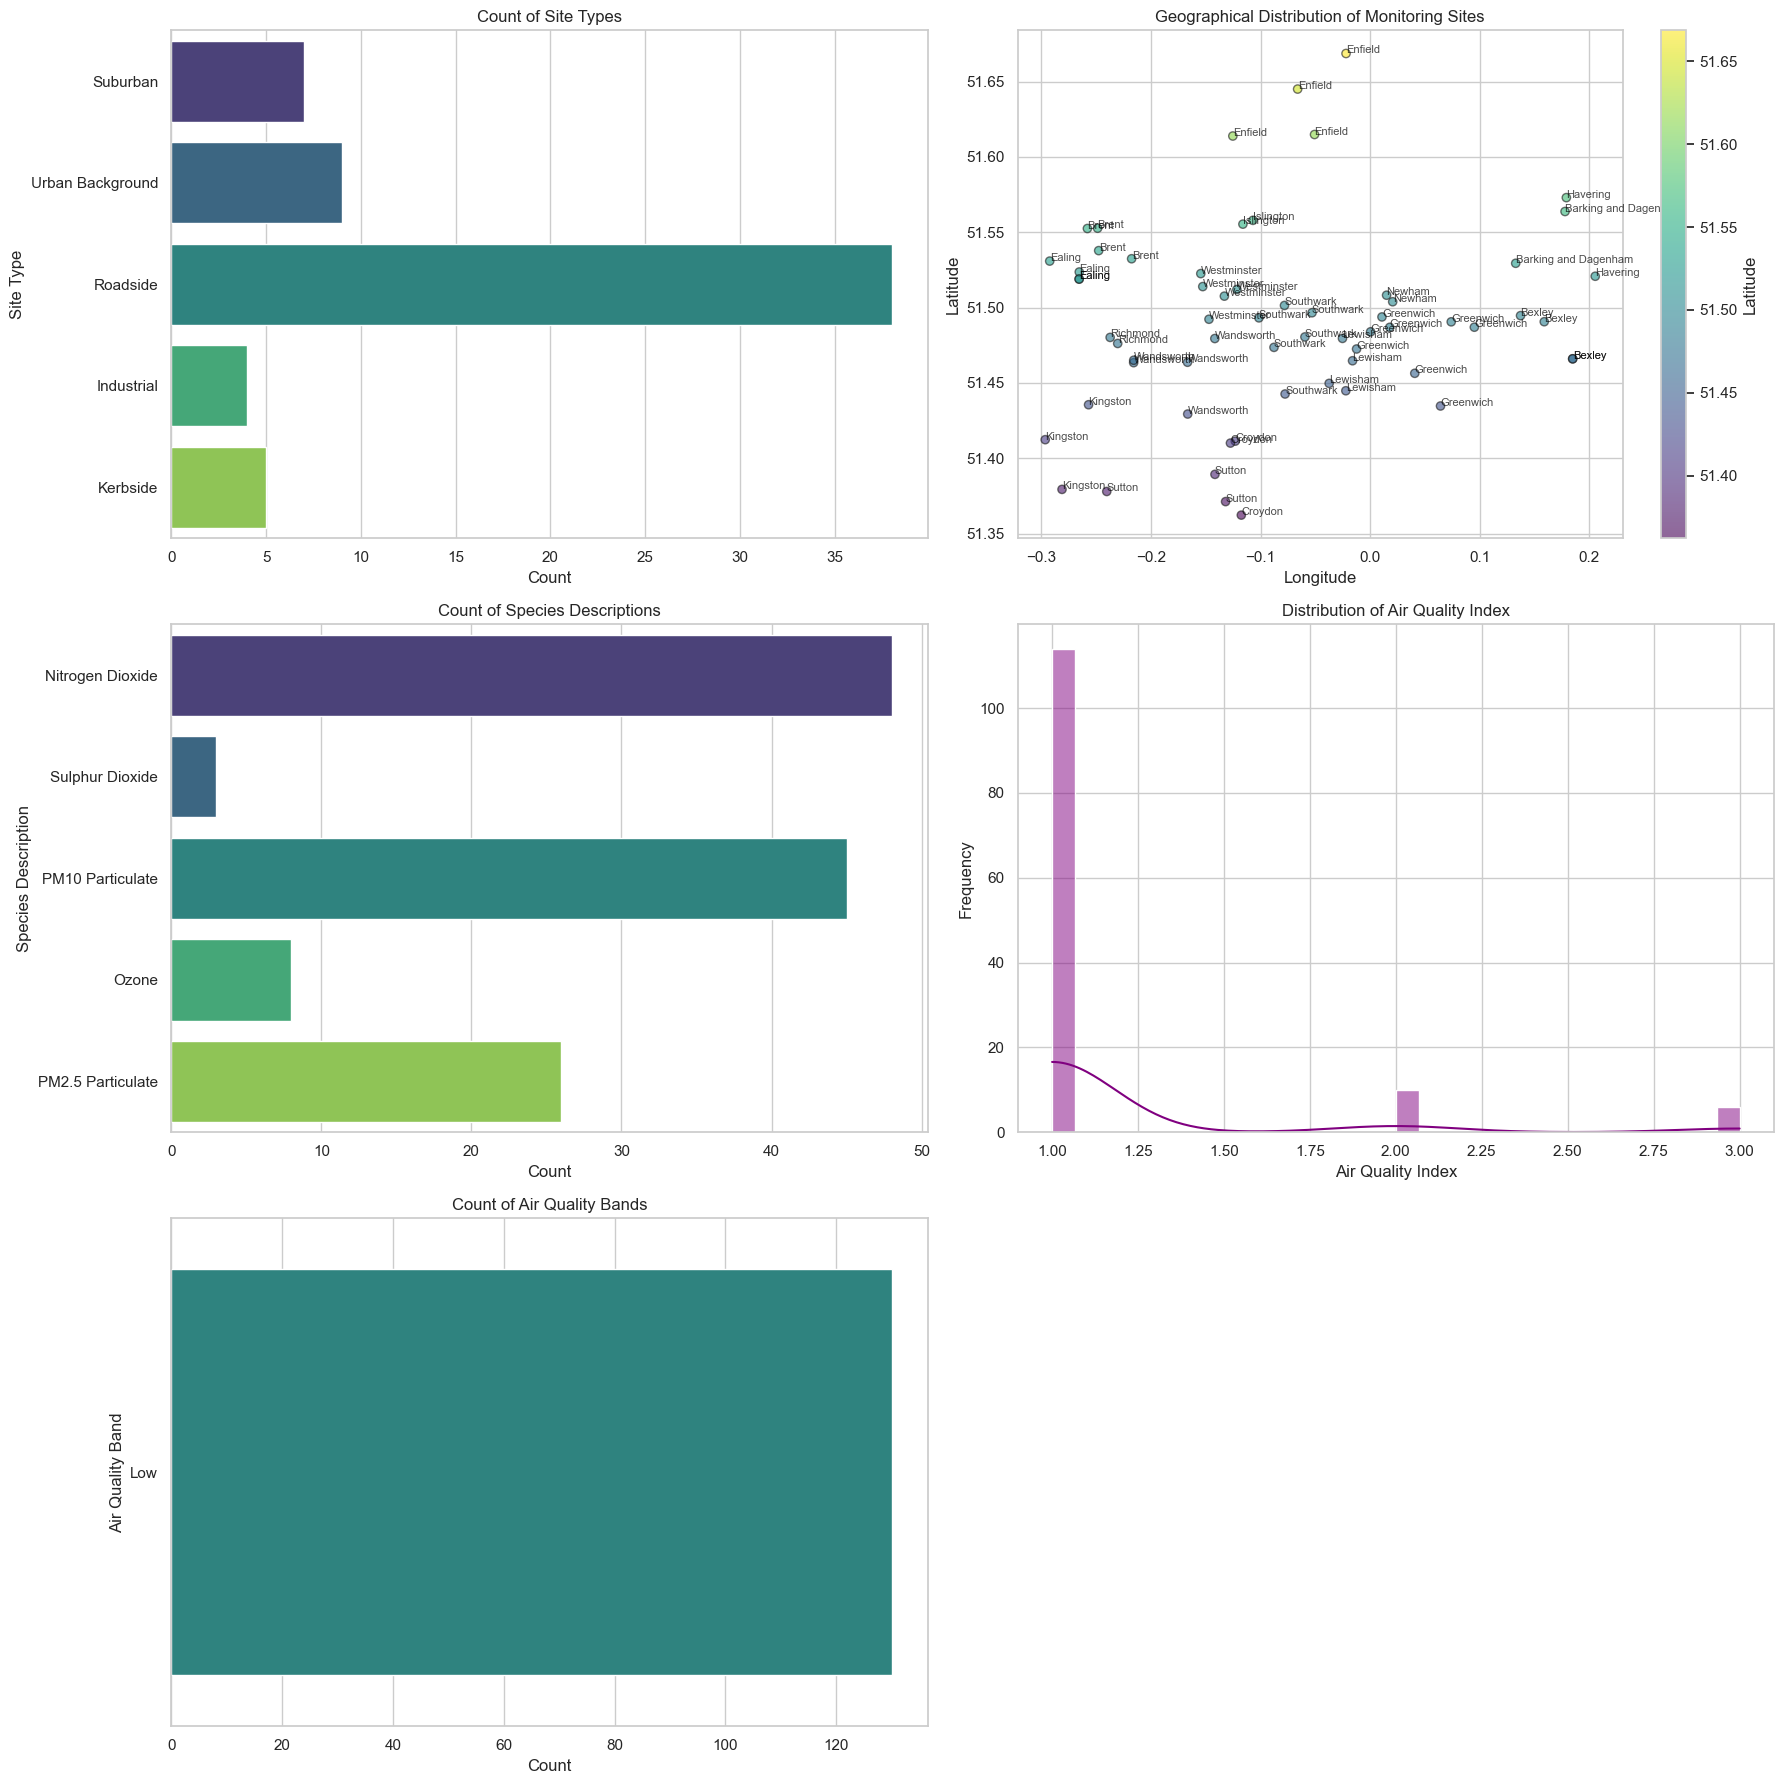

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the DataFrames are already available as df_authorities, df_sites, df_species

# Convert AirQualityIndex to numeric
df_species['AirQualityIndex'] = pd.to_numeric(df_species['AirQualityIndex'], errors='coerce')

# Convert Latitude and Longitude to numeric
df_sites['Latitude'] = pd.to_numeric(df_sites['Latitude'], errors='coerce')
df_sites['Longitude'] = pd.to_numeric(df_sites['Longitude'], errors='coerce')

# Set up the plotting environment
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", as_cmap=True)

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# 1. Count of Site Types
sns.countplot(y='SiteType', data=df_sites, hue='SiteType', palette='viridis', ax=axs[0, 0], dodge=False)
axs[0, 0].set_title('Count of Site Types')
axs[0, 0].set_xlabel('Count')
axs[0, 0].set_ylabel('Site Type')
axs[0, 0].legend().remove()

# 2. Geographical Distribution of Sites with Labels
sc = axs[0, 1].scatter(df_sites['Longitude'], df_sites['Latitude'], alpha=0.6, c=df_sites['Latitude'], cmap='viridis', edgecolor='k')
for i, row in df_sites.iterrows():
    axs[0, 1].text(row['Longitude'], row['Latitude'], row['LocalAuthorityName'], fontsize=8, alpha=0.7, color='black')
axs[0, 1].set_title('Geographical Distribution of Monitoring Sites')
axs[0, 1].set_xlabel('Longitude')
axs[0, 1].set_ylabel('Latitude')
fig.colorbar(sc, ax=axs[0, 1], label='Latitude')

# 3. Count of Species Descriptions
sns.countplot(y='SpeciesDescription', data=df_species, hue='SpeciesDescription', palette='viridis', ax=axs[1, 0], dodge=False)
axs[1, 0].set_title('Count of Species Descriptions')
axs[1, 0].set_xlabel('Count')
axs[1, 0].set_ylabel('Species Description')
axs[1, 0].legend().remove()

# 4. Distribution of Air Quality Index
sns.histplot(df_species['AirQualityIndex'], bins=30, kde=True, color='purple', ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Air Quality Index')
axs[1, 1].set_xlabel('Air Quality Index')
axs[1, 1].set_ylabel('Frequency')

# 5. Count of Air Quality Bands
sns.countplot(y='AirQualityBand', data=df_species, hue='AirQualityBand', palette='viridis', ax=axs[2, 0], dodge=False)
axs[2, 0].set_title('Count of Air Quality Bands')
axs[2, 0].set_xlabel('Count')
axs[2, 0].set_ylabel('Air Quality Band')
axs[2, 0].legend().remove()

# Remove the empty subplot (2,1)
fig.delaxes(axs[2, 1])

# Adjust layout
plt.tight_layout()
plt.show()


I don't like the geographical plot, it's messy. Let's try making a nicer one with Folium. 

In [25]:
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm

# Convert Latitude and Longitude to numeric
df_sites['Latitude'] = pd.to_numeric(df_sites['Latitude'], errors='coerce')
df_sites['Longitude'] = pd.to_numeric(df_sites['Longitude'], errors='coerce')


# Define colors for each site type
site_types = df_sites['SiteType'].unique()
colors = sns.color_palette('husl', len(site_types)).as_hex()
color_dict = dict(zip(site_types, colors))


# Map the colors to folium colors
color_mapping = dict(zip(site_types, folium_colors[:len(site_types)]))

# Create a base map
m = folium.Map(location=[51.5074, -0.1278], zoom_start=10, tiles='cartodbpositron')  # Use 'Stamen Terrain' or 'OpenStreetMap'

# Add a satellite tile layer
folium.TileLayer('stamenterrain', name='Satellite', attr="<a href=https://www.londonair.org.uk/LondonAir/API/>London Air</a>").add_to(m)

# Create a MarkerCluster
marker_cluster = MarkerCluster().add_to(m)


# Add points to the map with color-coded markers
for i, row in df_sites.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=6,
        color=color_dict[row['SiteType']],
        fill=True,
        fill_color=color_dict[row['SiteType']],
        fill_opacity=0.7,
        popup=row['LocalAuthorityName']
    ).add_to(marker_cluster)

# Add layer control
folium.LayerControl().add_to(m)


# Create a legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 250px; height: auto; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color: white;
                 padding: 10px;
                 ">
     &nbsp; <b>Site Type Legend</b> <br>
     {legend_items}
     </div>
     '''

legend_items = ''
for site_type, color in color_dict.items():
    legend_items += f'<div><svg width="10" height="10"><circle cx="5" cy="5" r="5" fill="{color}" /></svg>&nbsp;{site_type}</div>'

legend_html = legend_html.format(legend_items=legend_items)

m.get_root().html.add_child(folium.Element(legend_html))



# Save the map as an HTML file
m.save('monitoring_sites_map.html')

# Display the map in a Jupyter notebook (optional)
m


Much better. This shows that the overwhelming site type is roadside (which we knew from before). It's also the foundation for a better time-series visualisation later on. 

Creating an SQLite database (or accessing the current one) and creating tables based on the structure we want, identifying the primary and foreign keys. 

In [42]:
# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('air_quality.db')
c = conn.cursor()

# Create tables for authorities, sites, and species
c.execute('''
    CREATE TABLE IF NOT EXISTS authorities (
        LocalAuthorityCode TEXT PRIMARY KEY,
        LocalAuthorityName TEXT,
        LaCentreLatitude TEXT,
        LaCentreLongitude TEXT,
        LaCentreLatitudeWGS84 TEXT,
        LaCentreLongitudeWGS84 TEXT
    )
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS sites (
        SiteCode TEXT PRIMARY KEY,
        SiteName TEXT,
        SiteType TEXT,
        Latitude TEXT,
        Longitude TEXT,
        LatitudeWGS84 TEXT,
        LongitudeWGS84 TEXT,
        BulletinDate TEXT,
        LocalAuthorityCode TEXT,
        FOREIGN KEY(LocalAuthorityCode) REFERENCES authorities(LocalAuthorityCode)
    )
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS species (
        SpeciesCode TEXT,
        SpeciesDescription TEXT,
        AirQualityIndex TEXT,
        AirQualityBand TEXT,
        IndexSource TEXT,
        SiteCode TEXT,
        FOREIGN KEY(SiteCode) REFERENCES sites(SiteCode)
    )
''')


In [43]:
# Insert data into tables
df_authorities.to_sql('authorities', conn, if_exists='replace', index=False)
df_sites.to_sql('sites', conn, if_exists='replace', index=False)
df_species.to_sql('species', conn, if_exists='replace', index=False)

# Commit and close connection
conn.commit()
conn.close()


In [44]:
# Reconnect to the database
conn = sqlite3.connect('air_quality.db')

# Read data into DataFrame
df_authorities = pd.read_sql_query('SELECT * FROM authorities', conn)
df_sites = pd.read_sql_query('SELECT * FROM sites', conn)
df_species = pd.read_sql_query('SELECT * FROM species', conn)


In [45]:

# Print column names to debug
print("Columns in df_species:", df_species.columns)


Columns in df_species: Index(['SpeciesCode', 'SpeciesDescription', 'AirQualityIndex',
       'AirQualityBand', 'IndexSource', 'SiteCode', 'SiteName'],
      dtype='object')


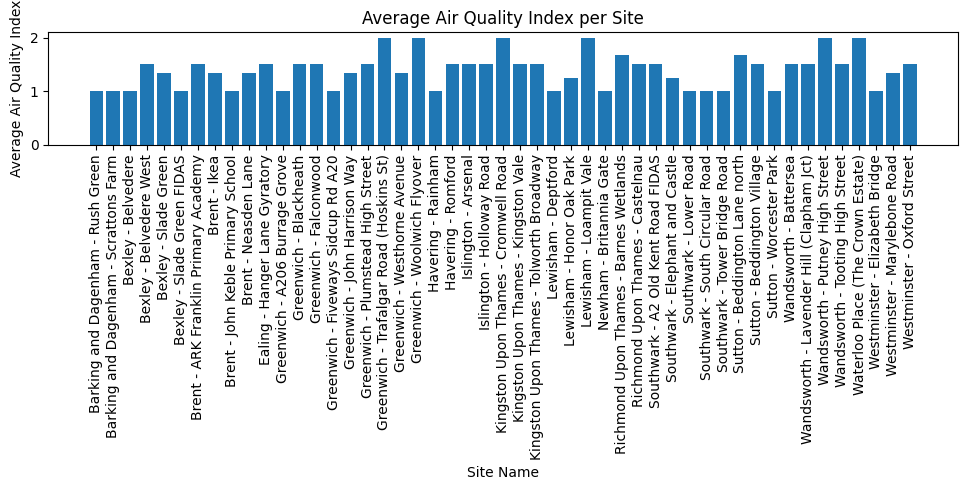

In [32]:
# Perform analysis: Calculate average air quality index per site
df_species['@AirQualityIndex'] = pd.to_numeric(df_species['@AirQualityIndex'], errors='coerce')
average_aqi = df_species.groupby('SiteName')['@AirQualityIndex'].mean().reset_index()

# Visualization: Bar plot of average air quality index per site
plt.figure(figsize=(10, 5))
plt.bar(average_aqi['SiteName'], average_aqi['@AirQualityIndex'])
plt.xlabel('Site Name')
plt.ylabel('Average Air Quality Index')
plt.title('Average Air Quality Index per Site')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Close the database connection
conn.close()


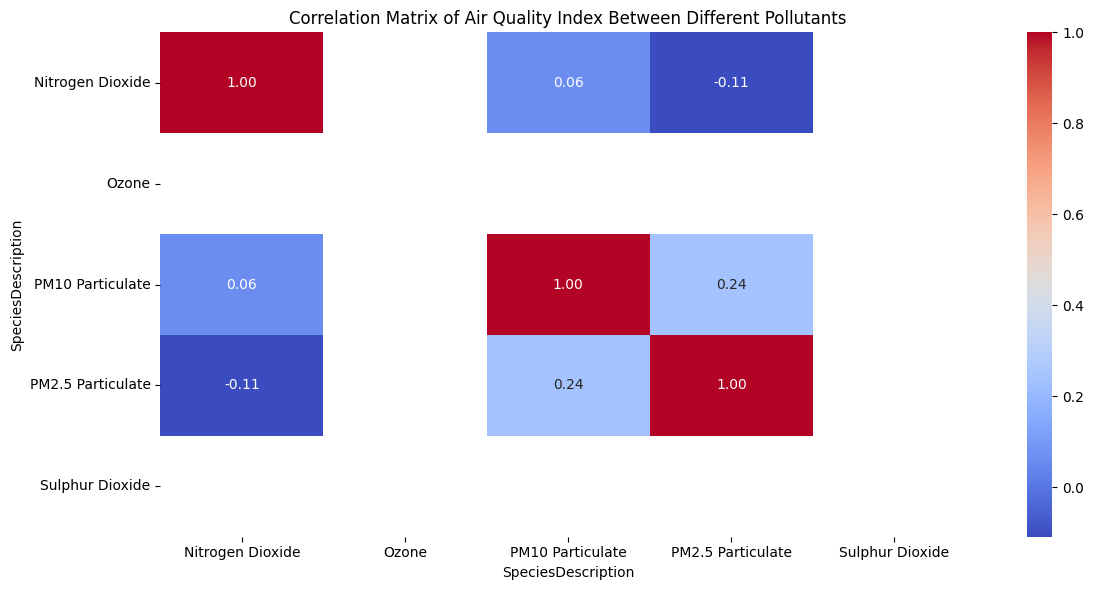

In [54]:
# Reconnect to the database
conn = sqlite3.connect('air_quality.db')

# Example SQL query to get data for correlation analysis
query = '''
SELECT sites.SiteName, species.SpeciesDescription, species.AirQualityIndex
FROM species
JOIN sites ON species.SiteCode = sites.SiteCode
'''
df_corr = pd.read_sql_query(query, conn)
conn.close()

# Convert AirQualityIndex to numeric, coercing errors
df_corr['AirQualityIndex'] = pd.to_numeric(df_corr['AirQualityIndex'], errors='coerce')

# Pivot table to get pollutants as columns
df_corr_pivot = df_corr.pivot_table(index='SiteName', columns='SpeciesDescription', values='AirQualityIndex', aggfunc='mean')

# Calculate correlation matrix
corr_matrix = df_corr_pivot.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Air Quality Index Between Different Pollutants')
plt.tight_layout()
plt.show()


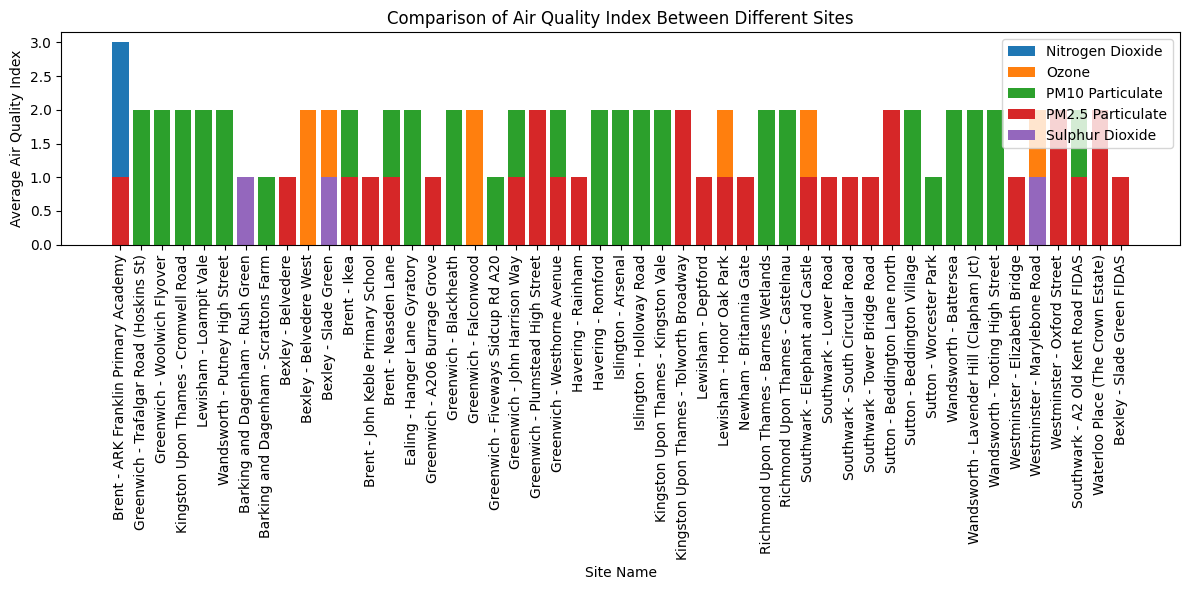

In [56]:
# Reconnect to the database
conn = sqlite3.connect('air_quality.db')

# Example SQL query to compare air quality between different sites
query = '''
SELECT sites.SiteName, species.SpeciesDescription, AVG(species.AirQualityIndex) as AvgAirQualityIndex
FROM species
JOIN sites ON species.SiteCode = sites.SiteCode
GROUP BY sites.SiteName, species.SpeciesDescription
ORDER BY AvgAirQualityIndex DESC
'''
df_comparison = pd.read_sql_query(query, conn)
conn.close()

# Convert AvgAirQualityIndex to numeric, coercing errors
df_comparison['AvgAirQualityIndex'] = pd.to_numeric(df_comparison['AvgAirQualityIndex'], errors='coerce')

# Plot comparison
plt.figure(figsize=(12, 6))
for species in df_comparison['SpeciesDescription'].unique():
    df_species = df_comparison[df_comparison['SpeciesDescription'] == species]
    plt.bar(df_species['SiteName'], df_species['AvgAirQualityIndex'], label=species)
plt.xlabel('Site Name')
plt.ylabel('Average Air Quality Index')
plt.title('Comparison of Air Quality Index Between Different Sites')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Reconnect to the database
conn = sqlite3.connect('air_quality.db')

# Example SQL query to get data for predictive modeling
query = '''
SELECT sites.SiteName, species.SpeciesDescription, species.AirQualityIndex
FROM species
JOIN sites ON species.SiteCode = sites.SiteCode
WHERE species.SpeciesDescription = 'Nitrogen Dioxide'
'''
df_model = pd.read_sql_query(query, conn)
conn.close()

# Convert AirQualityIndex to numeric, coercing errors
df_model['AirQualityIndex'] = pd.to_numeric(df_model['AirQualityIndex'], errors='coerce')

# Preprocess data
df_model = df_model.dropna()
df_model = pd.get_dummies(df_model, columns=['SiteName'])

# Split data into features and target
X = df_model.drop(['AirQualityIndex', 'SpeciesDescription'], axis=1)
y = df_model['AirQualityIndex']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Air Quality Index')
plt.ylabel('Predicted Air Quality Index')
plt.title('Actual vs Predicted Air Quality Index')
plt.tight_layout()
plt.show()


In [2]:
import requests
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to fetch data from the London Air API for a specific date
def fetch_air_quality_data(date):
    url = f"https://api.erg.ic.ac.uk/AirQuality/Daily/MonitoringIndex/GroupName=London/Date={date}/Json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        print(f"Got data for {date}")
        return data
    else:
        print(f"Failed to fetch data for {date}")
        return None

# Function to generate a list of dates for a given year
def generate_dates_for_year(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 1, 31)
    delta = end_date - start_date
    dates = [(start_date + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(delta.days + 1)]
    return dates

# Fetch and process data for an entire year
def fetch_yearly_data(year):
    dates = generate_dates_for_year(year)
    all_authorities = []
    all_sites = []
    all_species = []

    for date in dates:
        data = fetch_air_quality_data(date)
        if data:
            authorities = data['DailyAirQualityIndex']['LocalAuthority']
            all_authorities.extend(authorities)

            # Normalize sites within each authority
            for authority in authorities:
                if isinstance(authority.get('Site'), list):
                    for site in authority['Site']:
                        site['LocalAuthorityName'] = authority['@LocalAuthorityName']
                        site['LocalAuthorityCode'] = authority['@LocalAuthorityCode']
                        all_sites.append(site)

                        # Normalize species within each site
                        if isinstance(site.get('Species'), list):
                            for species in site['Species']:
                                species['SiteCode'] = site['@SiteCode']
                                species['SiteName'] = site['@SiteName']
                                all_species.append(species)

    return all_authorities, all_sites, all_species


In [3]:
# Fetch data for the year 2023 (or any desired year)
authorities, sites, species = fetch_yearly_data(2023)

Got data for 2023-01-01 2023-01-01
Got data for 2023-01-02 2023-01-02
Got data for 2023-01-03 2023-01-03
Got data for 2023-01-04 2023-01-04
Got data for 2023-01-05 2023-01-05
Got data for 2023-01-06 2023-01-06
Got data for 2023-01-07 2023-01-07
Got data for 2023-01-08 2023-01-08
Got data for 2023-01-09 2023-01-09
Got data for 2023-01-10 2023-01-10
Got data for 2023-01-11 2023-01-11
Got data for 2023-01-12 2023-01-12
Got data for 2023-01-13 2023-01-13
Got data for 2023-01-14 2023-01-14
Got data for 2023-01-15 2023-01-15
Got data for 2023-01-16 2023-01-16
Got data for 2023-01-17 2023-01-17
Got data for 2023-01-18 2023-01-18
Got data for 2023-01-19 2023-01-19
Got data for 2023-01-20 2023-01-20
Got data for 2023-01-21 2023-01-21
Got data for 2023-01-22 2023-01-22
Got data for 2023-01-23 2023-01-23
Got data for 2023-01-24 2023-01-24
Got data for 2023-01-25 2023-01-25
Got data for 2023-01-26 2023-01-26
Got data for 2023-01-27 2023-01-27
Got data for 2023-01-28 2023-01-28
Got data for 2023-01

/var/folders/cz/570p77r57bl87g4_l6l7xqw00000gn/T/ipykernel_87021/1950420510.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_authorities = df_authorities.applymap(lambda x: str(x) if isinstance(x, list) else x)
/var/folders/cz/570p77r57bl87g4_l6l7xqw00000gn/T/ipykernel_87021/1950420510.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_sites = df_sites.applymap(lambda x: str(x) if isinstance(x, list) else x)
/var/folders/cz/570p77r57bl87g4_l6l7xqw00000gn/T/ipykernel_87021/1950420510.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_species = df_species.applymap(lambda x: str(x) if isinstance(x, list) else x)


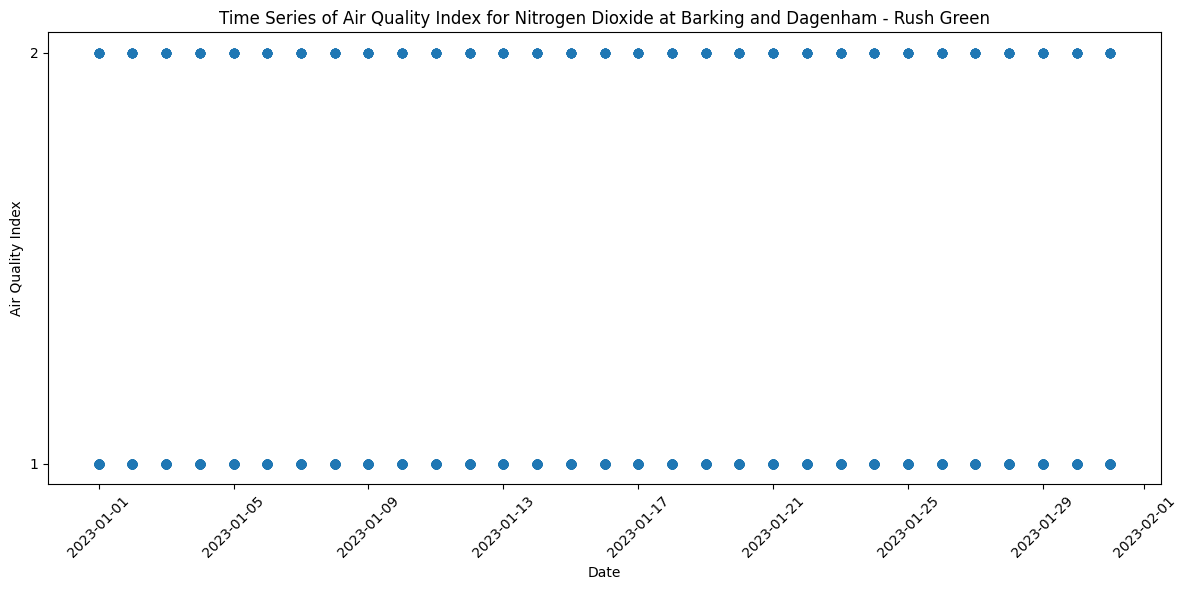

In [6]:

# Convert to DataFrames
df_authorities = pd.json_normalize(authorities)
df_sites = pd.json_normalize(sites)
df_species = pd.json_normalize(species)

# Remove special characters from column names
df_authorities.columns = [col.replace('@', '') for col in df_authorities.columns]
df_sites.columns = [col.replace('@', '') for col in df_sites.columns]
df_species.columns = [col.replace('@', '') for col in df_species.columns]

# Ensure all columns are of appropriate data types
df_authorities = df_authorities.applymap(lambda x: str(x) if isinstance(x, list) else x)
df_sites = df_sites.applymap(lambda x: str(x) if isinstance(x, list) else x)
df_species = df_species.applymap(lambda x: str(x) if isinstance(x, list) else x)

# Convert all columns to string type to avoid issues
df_authorities = df_authorities.astype(str)
df_sites = df_sites.astype(str)
df_species = df_species.astype(str)

# Connect to SQLite database (or create it if it doesn't exist)
conn = sqlite3.connect('air_quality.db')
c = conn.cursor()

# Create tables for authorities, sites, and species
c.execute('''
    CREATE TABLE IF NOT EXISTS authorities (
        LocalAuthorityCode TEXT PRIMARY KEY,
        LocalAuthorityName TEXT,
        LaCentreLatitude TEXT,
        LaCentreLongitude TEXT,
        LaCentreLatitudeWGS84 TEXT,
        LaCentreLongitudeWGS84 TEXT
    )
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS sites (
        SiteCode TEXT PRIMARY KEY,
        SiteName TEXT,
        SiteType TEXT,
        Latitude TEXT,
        Longitude TEXT,
        LatitudeWGS84 TEXT,
        LongitudeWGS84 TEXT,
        BulletinDate TEXT,
        LocalAuthorityCode TEXT,
        FOREIGN KEY(LocalAuthorityCode) REFERENCES authorities(LocalAuthorityCode)
    )
''')

c.execute('''
    CREATE TABLE IF NOT EXISTS species (
        SpeciesCode TEXT,
        SpeciesDescription TEXT,
        AirQualityIndex TEXT,
        AirQualityBand TEXT,
        IndexSource TEXT,
        SiteCode TEXT,
        SiteName TEXT,
        FOREIGN KEY(SiteCode) REFERENCES sites(SiteCode)
    )
''')

# Insert data into tables
df_authorities.to_sql('authorities', conn, if_exists='replace', index=False)
df_sites.to_sql('sites', conn, if_exists='replace', index=False)
df_species.to_sql('species', conn, if_exists='replace', index=False)

# Commit and close connection
conn.commit()
conn.close()

# Example Analysis: Time Series Analysis

# Reconnect to the database
conn = sqlite3.connect('air_quality.db')

# Example SQL query to get time series data for a particular site and species
query = '''
SELECT sites.BulletinDate, sites.SiteName, species.AirQualityIndex
FROM species
JOIN sites ON species.SiteCode = sites.SiteCode
WHERE sites.SiteName = 'Barking and Dagenham - Rush Green' AND species.SpeciesDescription = 'Nitrogen Dioxide'
ORDER BY sites.BulletinDate
'''
df_time_series = pd.read_sql_query(query, conn)
conn.close()

# Convert BulletinDate to datetime
df_time_series['BulletinDate'] = pd.to_datetime(df_time_series['BulletinDate'])

# Plot time series
plt.figure(figsize=(12, 6))
plt.scatter(df_time_series['BulletinDate'], df_time_series['AirQualityIndex'])
plt.xlabel('Date')
plt.ylabel('Air Quality Index')
plt.title('Time Series of Air Quality Index for Nitrogen Dioxide at Barking and Dagenham - Rush Green')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
